# 3.8.1 Monotonic XGBoost Model
#### and comparison with non-monotonic model

## 1) Load Required Libraries

In [82]:
library("dplyr")
library("ggplot2")
library("ROSE")
library("xgboost")
library("gbm")
library("Matrix")
library("pdp") 
library("caret")
library("mltools")
library("data.table")
library("pROC")
library("PRROC")
library("rBayesianOptimization")
library("DiagrammeR")
library("MLmetrics")

## 2) Load Data

In [2]:
transformed2.df <- read.csv(file="TransfromedData2.csv", header=TRUE, sep=",")
glimpse(transformed2.df)

Observations: 884,570
Variables: 27
$ X                                      <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,…
$ loan_amnt                              <int> 5600, 7500, 12200, 11200, 2500…
$ term                                   <fct>  36 months,  36 months,  36 mo…
$ int_rate                               <dbl> 18.04, 13.87, 12.29, 11.34, 15…
$ installment                            <dbl> 202.57, 255.86, 406.91, 368.48…
$ grade                                  <fct> G, D, C, C, E, C, C, A, B, C, …
$ home_ownership                         <fct> OWN, MORTGAGE, OWN, RENT, MORT…
$ annual_inc                             <dbl> 0.6677529, 0.7174611, 0.661276…
$ verification_status                    <fct> Not Verified, Not Verified, No…
$ pymnt_plan                             <fct> n, n, n, n, n, n, n, n, n, n, …
$ purpose                                <fct> home_improvement, Others, home…
$ dti                                    <dbl> 25.84, 20.95, 9.31, 6.92, 6.82…
$ open_acc      

## 3) Transform Data for Modelling

### 3.1) Basic Transforms

Convert all factor levels to uppercase and replace spaces for underscores to make them more readable

In [3]:
transformed2.df <- transformed2.df %>% mutate(term = factor(term, labels = c('36MO', '60MO')),
        verification_status = factor(verification_status, labels = c('NOT_VERIFIED', 'SOURCE_VERIFIED', 'VERIFIED')),
        purpose = factor(purpose, labels = c('CREDIT_CARD', 'DEBT_CONSOLIDATION', 'HOME_IMPROVEMENT', 'MAJOR_PURCHASE', 'OTHERS', 'SMALL_BUSINESS')),
        initial_list_status = factor(initial_list_status, labels = c('F', 'W')),
        regions = factor(regions, labels = c('MIDWEST', 'NORTHEAST', 'SOUTH', 'WEST')),
        pymnt_plan = factor(pymnt_plan, labels = c("N", "Y")))

Rename external source columns for readability and ease of programmatic reference

In [4]:
transformed2.df <- transformed2.df %>% rename("compensation_of_employees" = "Compensation.of.employees", 
                           "gross_operating_surplus" = "Gross.operating.surplus",
                           "per_capita_real_gdp_by_state" = "Per.capita.real.GDP.by.state",
                           "quantity_indexes_for_real_gdp_by_state" = "Quantity.indexes.for.real.GDP.by.state",
                           "real_gdp_by_state" = "Real.GDP.by.state",
                           "subsidies" = "Subsidies",
                           "taxes_on_production_and_imports" = "Taxes.on.production.and.imports")

Add a `returns` with the amount expected to be gained from the loan from interests alone

In [5]:
transformed2.df <- transformed2.df %>% mutate(returns = (installment * ifelse(term=='36MO', 36, 60)) - loan_amnt)

Glimpse newly transformed dataframe

In [6]:
glimpse(transformed2.df)

Observations: 884,570
Variables: 28
$ X                                      <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,…
$ loan_amnt                              <int> 5600, 7500, 12200, 11200, 2500…
$ term                                   <fct> 36MO, 36MO, 36MO, 36MO, 36MO, …
$ int_rate                               <dbl> 18.04, 13.87, 12.29, 11.34, 15…
$ installment                            <dbl> 202.57, 255.86, 406.91, 368.48…
$ grade                                  <fct> G, D, C, C, E, C, C, A, B, C, …
$ home_ownership                         <fct> OWN, MORTGAGE, OWN, RENT, MORT…
$ annual_inc                             <dbl> 0.6677529, 0.7174611, 0.661276…
$ verification_status                    <fct> NOT_VERIFIED, NOT_VERIFIED, NO…
$ pymnt_plan                             <fct> N, N, N, N, N, N, N, N, N, N, …
$ purpose                                <fct> HOME_IMPROVEMENT, OTHERS, HOME…
$ dti                                    <dbl> 25.84, 20.95, 9.31, 6.92, 6.82…
$ open_acc      

### 3.2) One-hot encoded version (for monotonic constraints)

In [7]:
transformed2.1hot.df <- one_hot(as.data.table(transformed2.df))
glimpse(transformed2.1hot.df)

Observations: 884,570
Variables: 50
$ X                                      <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,…
$ loan_amnt                              <int> 5600, 7500, 12200, 11200, 2500…
$ term_36MO                              <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ term_60MO                              <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ int_rate                               <dbl> 18.04, 13.87, 12.29, 11.34, 15…
$ installment                            <dbl> 202.57, 255.86, 406.91, 368.48…
$ grade_A                                <int> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, …
$ grade_B                                <int> 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, …
$ grade_C                                <int> 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, …
$ grade_D                                <int> 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, …
$ grade_E                                <int> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, …
$ grade_F                                <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ grade_G       

### 3.3) Train / Test split both versions

Initialize Seed

In [8]:
seedNum = 19
set.seed(seedNum)

Create partitions

In [9]:
train.indx <- createDataPartition(y=transformed2.df$default, p=0.85, list=FALSE)
train.1hot.df <- transformed2.1hot.df[train.indx,-1]
test.1hot.df <- transformed2.1hot.df[-train.indx,-1]
train.df <- transformed2.df[train.indx,-1]
test.df <- transformed2.df[-train.indx,-1]

In [247]:
write.csv(transformed2.1hot.df[train.indx,], file = "train.1hot.df.csv")
write.csv(transformed2.1hot.df[-train.indx,], file = "test.1hot.df.csv")
write.csv(transformed2.df[train.indx,], file = "train.df.csv")
write.csv(transformed2.df[-train.indx,], file = "test.df.csv")

### 3.4) Create sampled versions of both training datasets (for cross validation)

Undersample train dataset for cross validation 

In [10]:
train.samp.indx <- createDataPartition(y=train.df$default, p=0.15, list=FALSE)
train.samp.df <- transformed2.1hot.df[train.samp.indx,-1]
train.samp.1hot.df <- transformed2.1hot.df[train.samp.indx,-1]

### 3.4) Calculate Sampled Medians (for Cost Sensitive Learning & Evaluation )

Calculate mean sample returns

In [11]:
mreturns <- median(train.1hot.df$returns)
mreturns

[1] 2786.8

Median sample loan amount

In [12]:
mloan_amnt <- median(train.1hot.df$loan_amnt)
mloan_amnt

[1] 13000

### 3.6) Generate Y/X Sets for all versions

Remove returns from all training set to

In [13]:
y_train <- subset(train.1hot.df, select=default)
y_train.samp <- subset(train.samp.1hot.df, select=default)
x_train <- subset(train.df, select=-c(default, returns))
x_train.samp <- subset(train.samp.df, select=-c(default, returns))
y_test <- subset(test.1hot.df, select=default)
x_test <- subset(test.df, select=-c(default, returns))
x_train.1hot <- subset(train.1hot.df, select=-c(default, returns))
x_train.samp.1hot <- subset(train.samp.1hot.df, select=-c(default, returns))
x_test.1hot <- subset(test.1hot.df, select=-c(default, returns))

### 3.7) Create Constraint Matrix

**Calculate the Correlation Direction Between Response and Predictors**

In [14]:
mono <- cor(y_train, x_train.1hot, method = 'spearman', use="pairwise.complete.obs") / abs(cor(y_train, x_train.1hot, method = 'spearman', use="pairwise.complete.obs"))

Take a look at the constraints

In [15]:
glimpse(as.data.frame(mono))

Observations: 1
Variables: 47
$ loan_amnt                              <dbl> -1
$ term_36MO                              <dbl> -1
$ term_60MO                              <dbl> 1
$ int_rate                               <dbl> 1
$ installment                            <dbl> 1
$ grade_A                                <dbl> -1
$ grade_B                                <dbl> -1
$ grade_C                                <dbl> 1
$ grade_D                                <dbl> 1
$ grade_E                                <dbl> 1
$ grade_F                                <dbl> 1
$ grade_G                                <dbl> 1
$ home_ownership_MORTGAGE                <dbl> -1
$ home_ownership_OWN                     <dbl> -1
$ home_ownership_RENT                    <dbl> 1
$ annual_inc                             <dbl> -1
$ verification_status_NOT_VERIFIED       <dbl> -1
$ verification_status_SOURCE_VERIFIED    <dbl> -1
$ verification_status_VERIFIED           <dbl> 1
$ pymnt_plan_N                

### 3.8) Create DMatrixes

In [16]:
dtrain.1hot <- xgb.DMatrix(data = data.matrix(x_train.1hot), label = data.matrix(y_train))
dtrain.samp.1hot <- xgb.DMatrix(data = data.matrix(x_train.samp.1hot), label = data.matrix(y_train.samp))
dtrain.samp <- xgb.DMatrix(data = data.matrix(x_train.samp), label = data.matrix(y_train.samp))
dtrain <- xgb.DMatrix(data = data.matrix(x_train), label = data.matrix(y_train))

### 3.9) Create Folds on Sampling

In [17]:
cv_folds <- KFold(y_train.samp$default, nfolds = 5, stratified = FALSE, seed=seedNum)

## 4) Modelling

### 4.1) Monotonic Constrained XGBoost

#### 4.1.1) Perform Hyperparameter Tuning with Bayesian Optimization and Cross Validation on the Training Data Sample

Optimize the PR AUC

In [18]:
xgb.mono.cv.bayes <- function(nround, max_depth, min_child_weight, eta, gamma) { # subsample, colsample_bytree, max_delta_step
    xgb.getLift <- function(preds, dtrain) {
        labels <- getinfo(dtrain, "label")
        lift <- getLift(preds, labels, thresholds[i])
        return(list(metric = "Lift", value = lift))
    }
    params <- list(
                    booster = "gbtree", #"gblinear", "dart"
                    max_depth = max_depth,
                    min_child_weight = min_child_weight,
                    eta = eta,
                    gamma = gamma,
                    subsample = 0.9, #subsample, 
                    colsample_bytree = 0.8, #colsample_bytree,
                    #max_delta_step = max_delta_step,
                    #lambda = 1, 
                    #alpha = 0,
                    objective = "binary:logistic",
                    eval_metric = "aucpr", 
                    monotone_constraints = mono
                 )
    cv <- xgb.cv(params = params, data = dtrain.samp.1hot, folds = cv_folds, nrounds = 300, 
                 early_stopping_rounds = 20, maximize = TRUE, verbose = TRUE, print_every_n=20)
    return(list(Score = cv$evaluation_log$test_aucpr_mean[cv$best_iteration], Pred=cv$best_iteration))
}

In [19]:
stime <- Sys.time()
xgb.mono.cv.bayes.opt <- BayesianOptimization(xgb.mono.cv.bayes,
                              bounds = list(max_depth = c(3L, 15L), 
                                            min_child_weight = c(1L, 7L),
                                            eta=c(0.05, 0.3),
                                            gamma = c(0.0, 0.4) #,
                                            #subsample = c(0.6, 0.9),
                                            #colsample_bytree=c(0.3, 0.7),
                                            #max_delta_step=c(1L, 10L)
                                        ),
                              init_grid_dt = NULL, init_points = 10, n_iter = 10,
                              acq = "ucb", kappa = 2.576, eps = 0.0, verbose = FALSE)
print(Sys.time() - stime)


 Best Parameters Found: 
Round = 11	max_depth = 5.0000	min_child_weight = 6.0000	eta = 0.0751	gamma = 0.3117	Value = 0.1692 
Time difference of 20.6332 mins


**Bayesian Optimization History**

In [20]:
xgb.mono.cv.bayes.opt$History

Round,max_depth,min_child_weight,eta,gamma,Value
1,10,6,0.27433871,3.965552e-02,0.1678812
2,4,6,0.21047853,3.314499e-01,0.1685486
3,5,5,0.26499207,3.638495e-01,0.1676472
4,11,5,0.11324031,3.535268e-01,0.1687902
5,5,5,0.27523709,2.197864e-01,0.1681124
6,12,2,0.10558071,3.766433e-01,0.1683930
7,13,6,0.15469901,2.533106e-01,0.1682302
8,9,1,0.29712824,8.060083e-03,0.1681588
9,7,2,0.25850542,2.006403e-01,0.1682324
10,5,2,0.28158400,1.477750e-01,0.1660932


**Bayesian Optimization Best Parameters**

In [21]:
xgb.mono.cv.bayes.opt$Best_Par

max_depth min_child_weight              eta            gamma 
      5.00000000       6.00000000       0.07514248       0.31172759

**Set Optimal # Rounds**

In [22]:
xgb.mono.cv.bayes.opt.nrounds <- xgb.mono.cv.bayes.opt$Pred[[which.max(xgb.mono.cv.bayes.opt$History$Value)]]
xgb.mono.cv.bayes.opt.nrounds

[1] 229

#### 4.1.2) Perform Cost Sensitive Learning with Cross Validation on the Training Data Sample

**Objective Functions to Test**

In [23]:
#To Minimize
getCost <- function(obs, pred, threshold = 0.5) {
    tp_num <- sum(obs == 1 & obs == pred) #No Value assigned
    tn_num <- sum(obs == 0 & obs == pred) #No Value assigned
    fp_num <- sum(obs == 0 & obs != pred) #Value of median loan_amnt 
    fn_num <- sum(obs == 1 & obs != pred) #Value of median returns
    profit <- (tn_num * mreturns) + (fn_num * mloan_amnt)
    return(profit)
}

#To Maximize
getProfit <- function(obs, pred, threshold = 0.5) {
    pred <- ifelse(pred >= threshold, 1, 0)
    tp_num <- sum(obs == 1 & obs == pred) #No Value assigned
    tn_num <- sum(obs == 0 & obs == pred) #Value of median returns
    fp_num <- sum(obs == 0 & obs != pred) #No Value assigned
    fn_num <- sum(obs == 1 & obs != pred) #Value of median loan_amnt
    #print(sprintf("%s, %s, %s, %s", tp_num, tn_num, fp_num, fn_num))
    profit <- (tn_num * mreturns) - (fn_num * mloan_amnt)
    return(profit)
}

# Predict non-returning for everyone
getBenchmarkProfit <- function(obs) { 
  n <- length(obs)
  getProfit(obs, rep(0, times = n))
}

getLift <- function(probs, labels, thresh) {
    pred_profit <- as.numeric(getProfit(obs = labels,
                                      pred = probs,
                                      threshold = thresh))
    naive_profit <- as.numeric(getBenchmarkProfit(labels))
    profit_lift <- pred_profit/naive_profit
    #print(sprintf("%.2f / %.2f = %.4f", pred_profit, naive_profit, profit_lift))
    return(profit_lift)
}

**Custom Cost Sensitive Learning Function**

In [24]:
CSL <- function(params, data, nfold, nrounds, tstart, tend, tinterval, feval = "lift", verbose = FALSE, print_every_n = 50){
    thresholds <- seq(tstart, tend, by = tinterval)
    performance <- vector(length = length(thresholds))
    for(i in 1:length(thresholds)) {
        print(paste(i, ":", thresholds[i]))
        xgb.getCost <- function(preds, dtrain) {
            labels <- getinfo(dtrain, "label")
            cost <- getCost(labels, preds, thresholds[i])
            return(list(metric = "Cost", value = cost))
        }
        xgb.getLift <- function(preds, dtrain) {
            labels <- getinfo(dtrain, "label")
            lift <- getLift(preds, labels, thresholds[i])
            return(list(metric = "Lift", value = lift))
        }
        # train the model again using the current threshold 
        if (feval == "lift"){
            xgb.csl <- xgb.cv(params = params, data = data, nfold = nfold,
                            nrounds = nrounds, feval = xgb.getLift, maximize = TRUE, 
                            early_stopping_rounds = 10, verbose = verbose, print_every_n = print_every_n)   
        }else{
            xgb.csl <- xgb.cv(params = params, data = data, nfold = nfold,
                            nrounds = nrounds, feval = xgb.getCost, maximize = FALSE, 
                            early_stopping_rounds = 10, verbose = verbose, print_every_n = print_every_n)  
        }
        # store results
        performance[i] <- as.data.frame(xgb.csl$evaluation_log)[xgb.csl$best_iteration,4]
    }
    return(list("thresholds" = thresholds, "performance" = performance))
}

**Run CSL on a 0.003 threshold interval**

In [25]:
params <- list(
                objective = "binary:logistic",
                eta = xgb.mono.cv.bayes.opt$Best_Par["eta"],
                max_depth = xgb.mono.cv.bayes.opt$Best_Par["max_depth"],
                gamma = xgb.mono.cv.bayes.opt$Best_Par["gamma"],
                min_child_weight = xgb.mono.cv.bayes.opt$Best_Par["min_child_weight"],
                subsample = 0.75,
                colsample_bytree = 1,
                monotone_constraints = mono
              )
stime <- Sys.time()
xgb.mono.CSL.cv.opt1 <- CSL(params, dtrain.samp.1hot, 5, xgb.mono.cv.bayes.opt.nrounds, 
                           0.1, 0.69, 0.03, feval = "lift")
print(Sys.time() - stime)

[1] "1 : 0.1"
[1] "2 : 0.13"
[1] "3 : 0.16"
[1] "4 : 0.19"
[1] "5 : 0.22"
[1] "6 : 0.25"
[1] "7 : 0.28"
[1] "8 : 0.31"
[1] "9 : 0.34"
[1] "10 : 0.37"
[1] "11 : 0.4"
[1] "12 : 0.43"
[1] "13 : 0.46"
[1] "14 : 0.49"
[1] "15 : 0.52"
[1] "16 : 0.55"
[1] "17 : 0.58"
[1] "18 : 0.61"
[1] "19 : 0.64"
[1] "20 : 0.67"
Time difference of 1.852866 mins


**Plot the lift for every threshold in the 0.10-0.69 range**

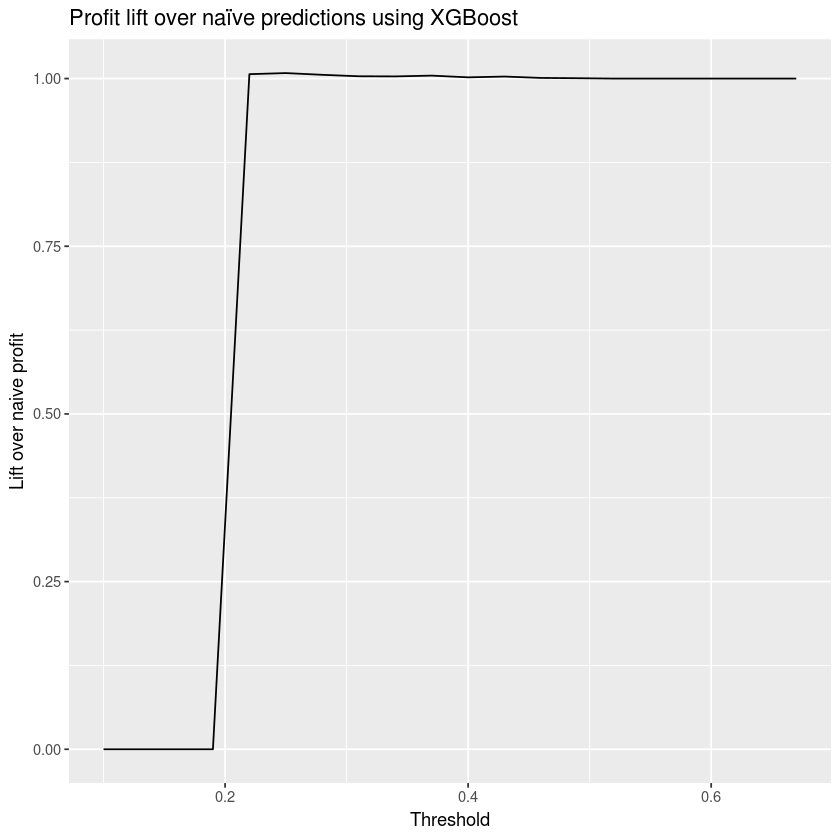

In [26]:
xgb.mono.CSL.cv.opt1.df <- as.data.frame(xgb.mono.CSL.cv.opt1)
ggplot(xgb.mono.CSL.cv.opt1.df, aes(x = thresholds, y = performance)) +
  geom_line() +
  labs(title = "Profit lift over naïve predictions using XGBoost",
          x = "Threshold", y = "Lift over naive profit")

**Set Optimal Threshold for CSL on a 0.03 scale**

In [27]:
xgb.mono.CSL.cv.opt1.threshold <- xgb.mono.CSL.cv.opt1.df$thresholds[which.max(xgb.mono.CSL.cv.opt1.df$performance)]
xgb.mono.CSL.cv.opt1.threshold

[1] 0.25

**Get more granular at a 0.005 threshold level**

In [28]:
params <- list(
                objective = "binary:logistic",
                eta = xgb.mono.cv.bayes.opt$Best_Par["eta"],
                max_depth = xgb.mono.cv.bayes.opt$Best_Par["max_depth"],
                gamma = xgb.mono.cv.bayes.opt$Best_Par["gamma"],
                min_child_weight = xgb.mono.cv.bayes.opt$Best_Par["min_child_weight"],
                subsample = 0.75,
                colsample_bytree = 1,
                monotone_constraints = mono
              )
stime <- Sys.time()
xgb.mono.CSL.cv.opt2 <- CSL(params, dtrain.samp.1hot, 5, xgb.mono.cv.bayes.opt.nrounds, 
                           xgb.mono.CSL.cv.opt1.threshold - 0.03, xgb.mono.CSL.cv.opt1.threshold + 0.03, 0.005, feval = "lift")
print(Sys.time() - stime)

[1] "1 : 0.22"
[1] "2 : 0.225"
[1] "3 : 0.23"
[1] "4 : 0.235"
[1] "5 : 0.24"
[1] "6 : 0.245"
[1] "7 : 0.25"
[1] "8 : 0.255"
[1] "9 : 0.26"
[1] "10 : 0.265"
[1] "11 : 0.27"
[1] "12 : 0.275"
[1] "13 : 0.28"
Time difference of 2.053602 mins


**Plot the lift for every threshold in the 0.13-0.19 range**

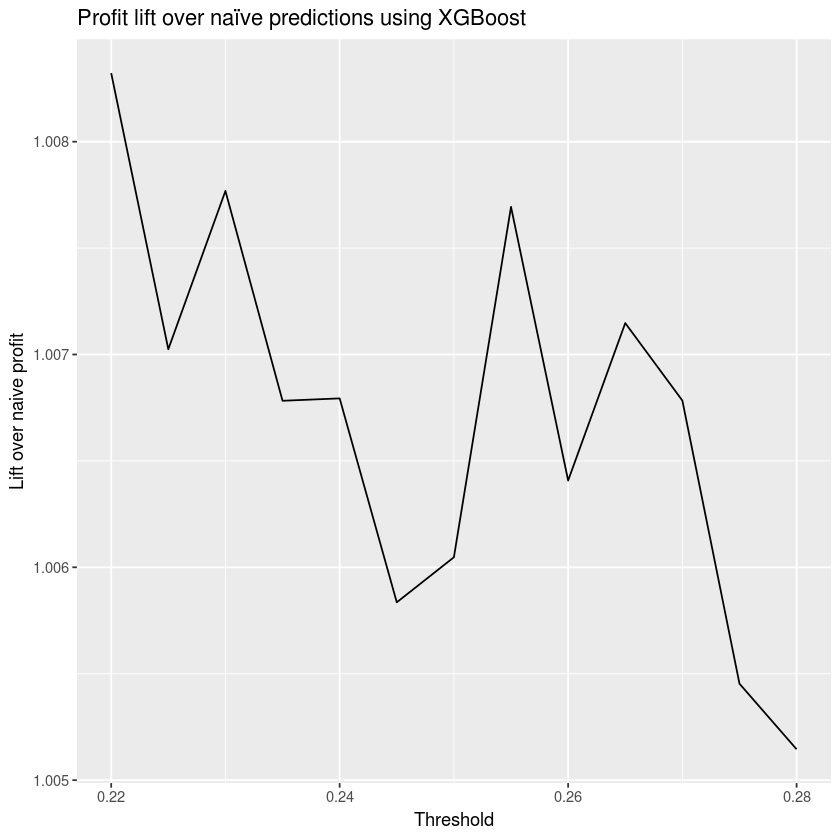

In [29]:
xgb.mono.CSL.cv.opt2.df <- as.data.frame(xgb.mono.CSL.cv.opt2)
ggplot(xgb.mono.CSL.cv.opt2.df, aes(x = thresholds, y = performance)) +
  geom_line() +
  labs(title = "Profit lift over naïve predictions using XGBoost",
          x = "Threshold", y = "Lift over naive profit")

**Set Optimal Threshold for CSL on a 0.005 scale**

In [30]:
xgb.mono.CSL.cv.opt2.threshold <- xgb.mono.CSL.cv.opt2.df$thresholds[which.max(xgb.mono.CSL.cv.opt2.df$performance)]
xgb.mono.CSL.cv.opt2.threshold

[1] 0.22

#### 4.1.3) Run & Test XGBoost on Optimal Params but on Full Training Set

**Set Optimal Params for Monotonic**

In [31]:
xgb.mono.cv.bayes.opt.params <- list(
    booster = "gbtree",
    max_depth = xgb.mono.cv.bayes.opt$Best_Par["max_depth"],
    min_child_weight = xgb.mono.cv.bayes.opt$Best_Par["min_child_weight"],
    eta = xgb.mono.cv.bayes.opt$Best_Par["eta"],
    gamma = xgb.mono.cv.bayes.opt$Best_Par["gamma"],
    subsample = 0.9, #xgb.mono.cv.bayes.opt$Best_Par["subsample"],
    colsample_bytree = 0.8, #xgb.mono.cv.bayes.opt$Best_Par["colsample_bytree"],
    #max_delta_step = xgb.mono.cv.bayes.opt$Best_Par["max_delta_step"], 
    objective = "binary:logistic",
    eval_metric=c("logloss", "auc", "aucpr", "error"),
    monotone_constraints = mono
)

**Train model on full training set**

In [32]:
stime <- Sys.time()
xgb.mono.opt.mdl <- xgb.train (params = xgb.mono.cv.bayes.opt.params, nrounds = xgb.mono.cv.bayes.opt.nrounds, data = dtrain.1hot, 
                              verbose=1, print_every_n=5)
print(Sys.time() - stime)

Time difference of 1.539833 mins


**Get Predictions using Test Dataset**

In [33]:
xgb.mono.opt.pred <- predict(xgb.mono.opt.mdl, as.matrix(x_test.1hot))

**Plot ROC Curve**

In [34]:
xgb.mono.opt.pred.fg <- xgb.mono.opt.pred[y_test$default==TRUE]
xgb.mono.opt.pred.bg <- xgb.mono.opt.pred[y_test$default==FALSE]

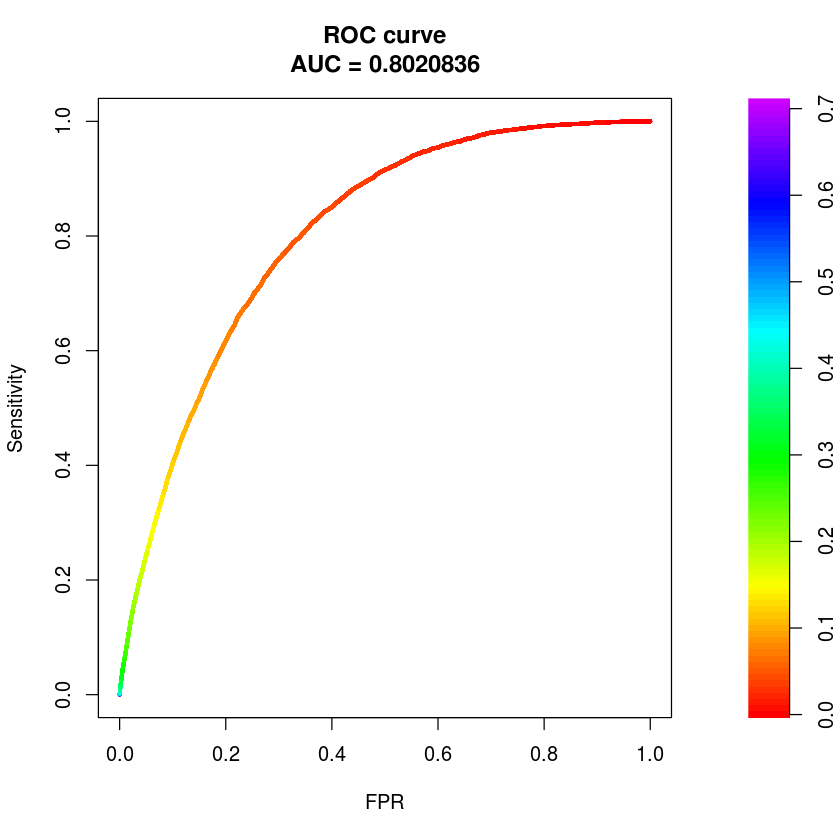

In [35]:
xgb.mono.opt.roc <- roc.curve(scores.class0 = xgb.mono.opt.pred.fg, scores.class1 = xgb.mono.opt.pred.bg, curve = T)
plot(xgb.mono.opt.roc)

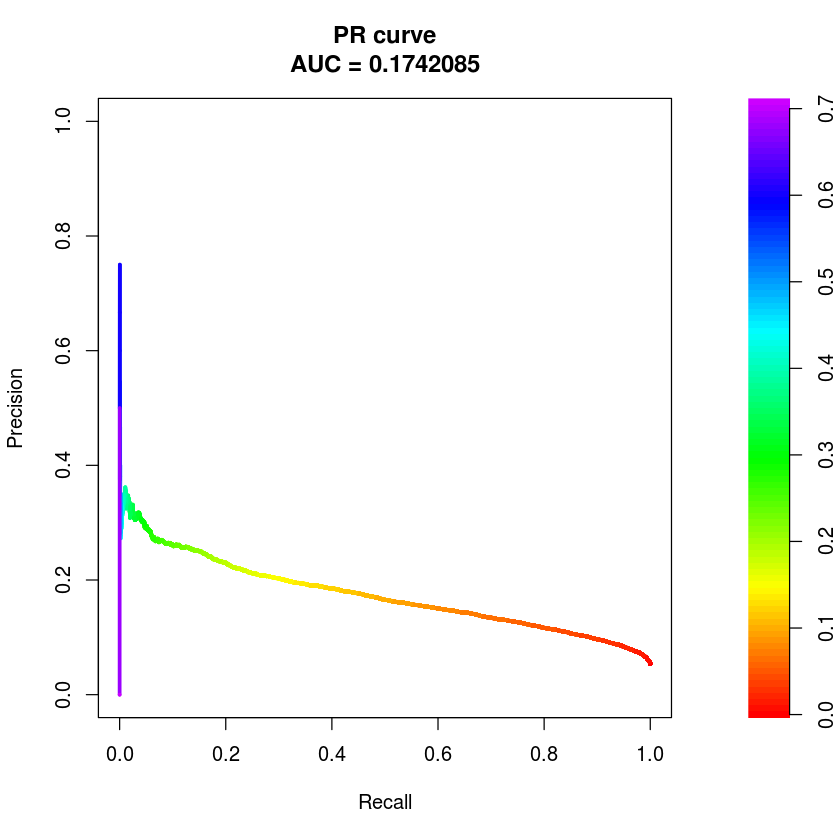

In [36]:
xgb.mono.opt.prc <- pr.curve(scores.class0 = xgb.mono.opt.pred.fg, scores.class1 = xgb.mono.opt.pred.bg, curve = T)
plot(xgb.mono.opt.prc)

**Calculate AUC**

In [37]:
xgb.mono.opt.auc <- auc(roc(y_test$default, xgb.mono.opt.pred))
xgb.mono.opt.auc

Area under the curve: 0.8021

**Calculate F-score**

In [38]:
xgb.mono.opt.f1 <- F1_Score(ifelse(xgb.mono.opt.pred > xgb.mono.CSL.cv.opt2.threshold, 1, 0), ifelse(y_test$default, 1, 0), positive = "0")
xgb.mono.opt.f1

[1] 0.9651388

**Generate and Save Confusion Matrix**

In [99]:
xgb.mono.opt.cm <- confusionMatrix(table(xgb.mono.opt.pred > xgb.mono.CSL.cv.opt2.threshold, y_test$default))
xgb.mono.opt.cm

Confusion Matrix and Statistics

       
         FALSE   TRUE
  FALSE 120939   5662
  TRUE    4683   1401
                                          
               Accuracy : 0.922           
                 95% CI : (0.9206, 0.9235)
    No Information Rate : 0.9468          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1724          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9627          
            Specificity : 0.1984          
         Pos Pred Value : 0.9553          
         Neg Pred Value : 0.2303          
             Prevalence : 0.9468          
         Detection Rate : 0.9115          
   Detection Prevalence : 0.9541          
      Balanced Accuracy : 0.5805          
                                          
       'Positive' Class : FALSE           
                                 

**Calculate Feature Importance/Influence**

In [40]:
xgb.mono.opt.imp <- xgb.importance(model = xgb.mono.opt.mdl)
print(xgb.mono.opt.imp)

                                   Feature         Gain        Cover
 1:                               int_rate 3.027121e-01 1.782937e-01
 2: quantity_indexes_for_real_gdp_by_state 2.068279e-01 1.417588e-01
 3:                  initial_list_status_F 7.374966e-02 5.085524e-02
 4:                      real_gdp_by_state 7.209323e-02 7.430250e-02
 5:                              subsidies 4.951181e-02 7.041468e-02
 6:                             annual_inc 4.227995e-02 6.046599e-02
 7:        taxes_on_production_and_imports 3.945428e-02 5.534083e-02
 8:                                  month 3.533584e-02 5.114343e-02
 9:              compensation_of_employees 3.286279e-02 3.411792e-02
10:                gross_operating_surplus 2.654717e-02 4.502726e-02
11:           per_capita_real_gdp_by_state 2.558498e-02 1.976713e-02
12:                  initial_list_status_W 1.765045e-02 1.035401e-02
13:                            installment 8.888659e-03 4.567262e-02
14:                 purpose_SMALL_

**Plot Importance/Influence**

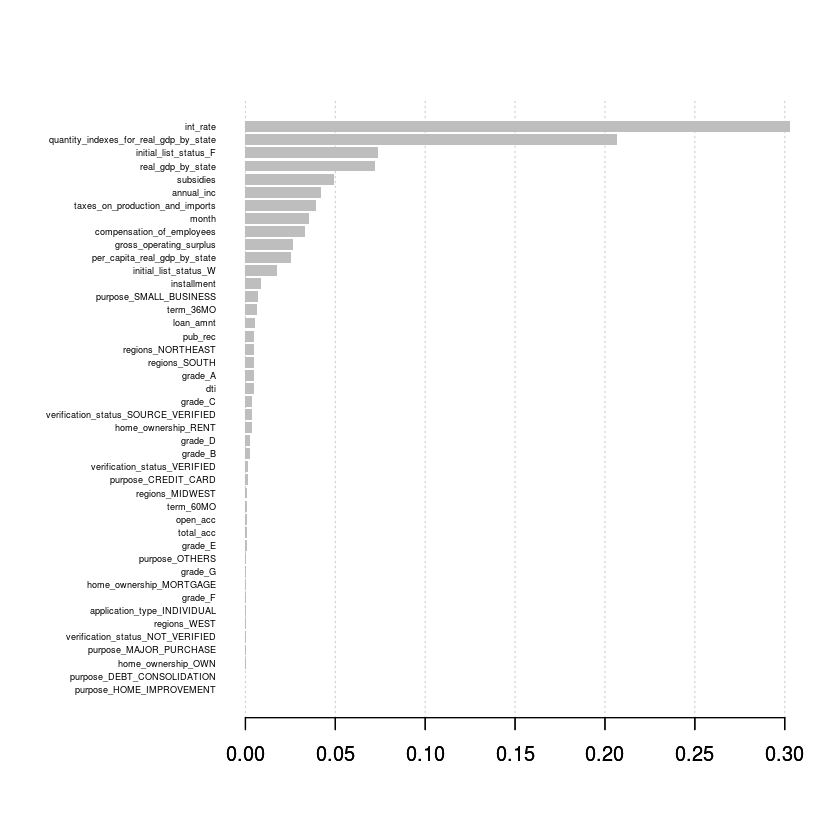

In [41]:
xgb.plot.importance(importance_matrix = xgb.mono.opt.imp)

**Dump Tree**

In [42]:
xgb.dump(xgb.mono.opt.mdl, with.stats = T, fname = "./models/xgb.mono.opt.tree.costopt.txt")

Warning message:
“'with.stats' is deprecated.
Use 'with_stats' instead.
See help("Deprecated") and help("xgboost-deprecated").”

[1] TRUE

**Save Model**

In [43]:
xgb.save(xgb.mono.opt.mdl, "./models/xgb.mono.opt.costopt.mdl")

[1] TRUE

**Partial Graph (for 3 top vars)**

In [44]:
stime <- Sys.time()
xgb.mono.opt.mdl.1p <- partial(xgb.mono.opt.mdl, pred.var = "int_rate", train = x_train.1hot,
                                 grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

Time difference of 11.43204 mins


In [45]:
stime <- Sys.time()
xgb.mono.opt.mdl.2p <- partial(xgb.mono.opt.mdl, pred.var = "quantity_indexes_for_real_gdp_by_state", train = x_train.1hot,
                                 grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

Time difference of 11.97422 mins


In [46]:
stime <- Sys.time()
xgb.mono.opt.mdl.3p <- partial(xgb.mono.opt.mdl, pred.var = "annual_inc", train = x_train.1hot,
                                 grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

Time difference of 11.93448 mins


#### 4.1.4) Calculate Model Relative Losses

**Losses ($L$)**: We cannot calculate the Loss Given Default (LGD) or Exposure to Default (EAD) precisely because we don't know what is the value of the collateral for each loan and administrative costs associated to a default so we are going to assume it's `loan_amnt` which is potentially a larger amount.

**Returns ($R$)**: We cannot calculate the Return on Allocated Equity (ROE) precisely because to do this we would need to factor cost of funds, income taxes and other costs associated in producing this money but we can calculate how much money is _yielded by the interest of each loan_ should it go to full term. Although this can be calculated using the compounded annualized `int_rate` on the `loan_amnt` for the duration of the `term` and deduct the `loan_amnt`. It's far easier to just leverage the `installment` column like this:

(`installment` * `term`) - `loan_amnt`

So I devised a way to best depict the relative amount of losses like this:

Cost Ratio = $\Large{\frac{L(FN) + R(FP)}{R(TN+FP)}}$ 

Which is the ratio produced by bad predictions over the total amount made by if everything was hypothetically a good prediction. In other words the total lost loan principals by false negatives plus the total lost in revenue by false positives over the total produced in revenue by all negatives (non-defaults).

On the other hand, we also used the profit lift ratio which was used for Bayesian Optimization of the hyperparameter tuning of the model which is:

Lift Ratio = $\Large{\frac{R(TN) - L(FN)}{\text{naïve: } R(TN)  - L(FN)}}$ 

In [252]:
xgb.mono.opt.NIR <- sum(xgb.mono.opt.cm$table[,1])/sum(xgb.mono.opt.cm$table)
xgb.mono.opt.costs <- ((xgb.mono.opt.cm$table[1,2]*mloan_amnt)+(xgb.mono.opt.cm$table[2,1]*mreturns))
xgb.mono.opt.profits <- (xgb.mono.opt.cm$table[1,1]*mreturns) - (xgb.mono.opt.cm$table[1,2]*mloan_amnt)
xgb.mono.opt.naive <- (round(xgb.mono.opt.NIR * sum(xgb.mono.opt.cm$table[1,]),0)*mreturns)-(round((1-xgb.mono.opt.NIR) * sum(xgb.mono.opt.cm$table[1,]),0)*mloan_amnt)
xgb.mono.opt.best <- ((sum(xgb.mono.opt.cm$table[,1])*mreturns))
xgb.mono.opt.worst <- (sum(xgb.mono.opt.cm$table[,1])*mreturns)+(sum(xgb.mono.opt.cm$table[,2])*mloan_amnt)
xgb.mono.opt.lift.ratio <- xgb.mono.opt.profits / xgb.mono.opt.naive
xgb.mono.opt.worst.ratio <- xgb.mono.opt.worst / xgb.mono.opt.best
xgb.mono.opt.cost.ratio <- xgb.mono.opt.costs / xgb.mono.opt.best
xgb.mono.opt.lift.ratio

[1] 1.068996

In [251]:
threshs <- seq(0.01, 0.3, by = 0.0025)
crs <- c()
rets <- c()
for(i in 1:length(threshs)) {
    cm <- confusionMatrix(table(xgb.mono.opt.pred > threshs[i], y_test$default))
    nir <- sum(cm$table[,1])/sum(cm$table)
    cr <-  ((cm$table[1,2]*mloan_amnt)+(cm$table[2,1]*mreturns)) / (sum(cm$table[,1])*mreturns)
    pr <-  (cm$table[1,1]*mreturns) - (cm$table[1,2]*mloan_amnt)
    nv <- (round(nir * sum(cm$table[1,]),0)*mreturns)-(round((1-nir) * sum(cm$table[1,]),0)*mloan_amnt)
    print(paste(threshs[i],pr/nv,sum(cm$table[,1])*mreturns))
    crs <- c(crs,pr/nv)
    rets <- c(rets, sum(cm$table[1,])*mreturns)
}
max(crs) #xgb.mono.CSL.cv.opt2.threshold = 0.185

[1] "0.01 1.409876400308 350083389.6"
[1] "0.0125 1.40476099777655 350083389.6"
[1] "0.015 1.39806817121177 350083389.6"
[1] "0.0175 1.39002593746939 350083389.6"
[1] "0.02 1.38312932320217 350083389.6"
[1] "0.0225 1.37634110485672 350083389.6"
[1] "0.025 1.37081252805342 350083389.6"
[1] "0.0275 1.36135863054007 350083389.6"
[1] "0.03 1.35467836633666 350083389.6"
[1] "0.0325 1.34598658885118 350083389.6"
[1] "0.035 1.33950246258306 350083389.6"
[1] "0.0375 1.33158705779945 350083389.6"
[1] "0.04 1.3234302946327 350083389.6"
[1] "0.0425 1.31718783461331 350083389.6"
[1] "0.045 1.30912147085888 350083389.6"
[1] "0.0475 1.30142119382327 350083389.6"
[1] "0.05 1.29351866229479 350083389.6"
[1] "0.0525 1.28661459415962 350083389.6"
[1] "0.055 1.2799884281448 350083389.6"
[1] "0.0575 1.27382582799561 350083389.6"
[1] "0.06 1.26595559025385 350083389.6"
[1] "0.0625 1.25761372863699 350083389.6"
[1] "0.065 1.25222122925724 350083389.6"
[1] "0.0675 1.24480951112471 350083389.6"
[1] "0.07 1.24

[1] 1.409876

### 4.2) Non-Monotonic Constrained XGBoost

#### 4.2.1) Perform Hyperparameter Tuning with Bayesian Optimization and Cross Validation on the Training Data Sample

Optimize the PR AUC

In [53]:
xgb.cv.bayes <- function(nround, max_depth, min_child_weight, eta, gamma) { # subsample, colsample_bytree, max_delta_step
    params <- list(
                    booster = "gbtree", #"gblinear", "dart"
                    max_depth = max_depth,
                    min_child_weight = min_child_weight,
                    eta = eta,
                    gamma = gamma,
                    subsample = 0.9, #subsample, 
                    colsample_bytree = 0.8, #colsample_bytree,
                    #max_delta_step = max_delta_step,
                    #lambda = 1, 
                    #alpha = 0,
                    objective = "binary:logistic",
                    eval_metric = "aucpr"
                 )
    cv <- xgb.cv(params = params, data = dtrain.samp.1hot, folds = cv_folds, nrounds = 500, 
                 early_stopping_rounds = 10, maximize = TRUE, verbose = TRUE, print_every_n=20)
    return(list(Score = cv$evaluation_log$test_aucpr_mean[cv$best_iteration], Pred=cv$best_iteration))
}

In [54]:
stime <- Sys.time()
xgb.cv.bayes.opt <- BayesianOptimization(xgb.cv.bayes,
                              bounds = list(max_depth = c(3L, 15L), 
                                            min_child_weight = c(1L, 7L),
                                            eta=c(0.05, 0.3),
                                            gamma = c(0.0, 0.4) #,
                                            #subsample = c(0.6, 0.9),
                                            #colsample_bytree=c(0.3, 0.7),
                                            #max_delta_step=c(1L, 10L)
                                        ),
                              init_grid_dt = NULL, init_points = 10, n_iter = 10,
                              acq = "ucb", kappa = 2.576, eps = 0.0, verbose = FALSE)
print(Sys.time() - stime)


 Best Parameters Found: 
Round = 12	max_depth = 3.0000	min_child_weight = 3.0000	eta = 0.0500	gamma = 0.1518	Value = 0.1829 
Time difference of 13.98026 mins


**Bayesian Optimization History**

In [55]:
xgb.cv.bayes.opt$History

Round,max_depth,min_child_weight,eta,gamma,Value
1,11,3,0.20096395,1.119322e-01,0.1633786
2,4,2,0.26775587,1.955466e-01,0.1771936
3,5,4,0.18150431,2.906475e-02,0.1741850
4,9,4,0.20856328,2.921487e-01,0.1673138
5,9,5,0.16171490,2.111039e-01,0.1667874
6,12,2,0.07037210,9.757713e-02,0.1644152
7,10,2,0.18517906,6.035988e-02,0.1638684
8,3,2,0.19190987,1.687915e-01,0.1806736
9,9,6,0.09300389,3.566921e-01,0.1715136
10,5,2,0.20507702,3.092699e-01,0.1764342


**Bayesian Optimization Best Parameters**

In [56]:
xgb.cv.bayes.opt$Best_Par

max_depth min_child_weight              eta            gamma 
       3.0000000        3.0000000        0.0500000        0.1517759

**Set Optimal # Rounds**

In [57]:
xgb.cv.bayes.opt.nrounds <- xgb.cv.bayes.opt$Pred[[which.max(xgb.cv.bayes.opt$History$Value)]]
xgb.cv.bayes.opt.nrounds

[1] 499

#### 4.1.2) Perform Cost Sensitive Learning with Cross Validation on the Training Data Sample

**Run CSL on a 0.003 threshold interval**

In [58]:
params <- list(
                objective = "binary:logistic",
                eta = xgb.cv.bayes.opt$Best_Par["eta"],
                max_depth = xgb.cv.bayes.opt$Best_Par["max_depth"],
                gamma = xgb.cv.bayes.opt$Best_Par["gamma"],
                min_child_weight = xgb.cv.bayes.opt$Best_Par["min_child_weight"],
                subsample = 0.75,
                colsample_bytree = 1
              )
stime <- Sys.time()
xgb.CSL.cv.opt1 <- CSL(params, dtrain.samp.1hot, 5, xgb.cv.bayes.opt.nrounds, 
                           0.1, 0.69, 0.03, feval = "lift")
print(Sys.time() - stime)

[1] "1 : 0.1"
[1] "2 : 0.13"
[1] "3 : 0.16"
[1] "4 : 0.19"
[1] "5 : 0.22"
[1] "6 : 0.25"
[1] "7 : 0.28"
[1] "8 : 0.31"
[1] "9 : 0.34"
[1] "10 : 0.37"
[1] "11 : 0.4"
[1] "12 : 0.43"
[1] "13 : 0.46"
[1] "14 : 0.49"
[1] "15 : 0.52"
[1] "16 : 0.55"
[1] "17 : 0.58"
[1] "18 : 0.61"
[1] "19 : 0.64"
[1] "20 : 0.67"
Time difference of 1.198393 mins


**Plot the lift for every threshold in the 0.10-0.69 range**

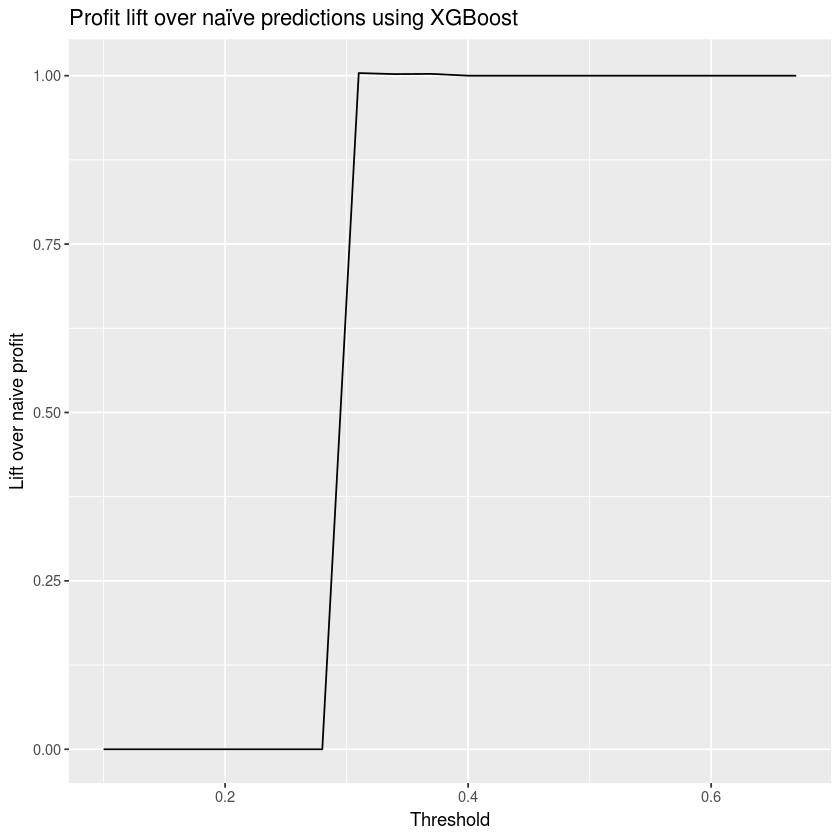

In [59]:
xgb.CSL.cv.opt1.df <- as.data.frame(xgb.CSL.cv.opt1)
ggplot(xgb.CSL.cv.opt1.df, aes(x = thresholds, y = performance)) +
  geom_line() +
  labs(title = "Profit lift over naïve predictions using XGBoost",
          x = "Threshold", y = "Lift over naive profit")

**Set Optimal Threshold for CSL on a 0.03 scale**

In [60]:
xgb.CSL.cv.opt1.threshold <- xgb.CSL.cv.opt1.df$thresholds[which.max(xgb.CSL.cv.opt1.df$performance)]
xgb.CSL.cv.opt1.threshold

[1] 0.31

**Get more granular at a 0.005 threshold level**

In [61]:
params <- list(
                objective = "binary:logistic",
                eta = xgb.cv.bayes.opt$Best_Par["eta"],
                max_depth = xgb.cv.bayes.opt$Best_Par["max_depth"],
                gamma = xgb.cv.bayes.opt$Best_Par["gamma"],
                min_child_weight = xgb.cv.bayes.opt$Best_Par["min_child_weight"],
                subsample = 0.75,
                colsample_bytree = 1,
                monotone_constraints = mono
              )
stime <- Sys.time()
xgb.CSL.cv.opt2 <- CSL(params, dtrain.samp.1hot, 5, xgb.cv.bayes.opt.nrounds, 
                           xgb.CSL.cv.opt1.threshold - 0.03, xgb.CSL.cv.opt1.threshold + 0.03, 0.005, feval = "lift")
print(Sys.time() - stime)

[1] "1 : 0.28"
[1] "2 : 0.285"
[1] "3 : 0.29"
[1] "4 : 0.295"
[1] "5 : 0.3"
[1] "6 : 0.305"
[1] "7 : 0.31"
[1] "8 : 0.315"
[1] "9 : 0.32"
[1] "10 : 0.325"
[1] "11 : 0.33"
[1] "12 : 0.335"
[1] "13 : 0.34"
Time difference of 1.267156 mins


**Plot the lift for every threshold in the 0.13-0.19 range**

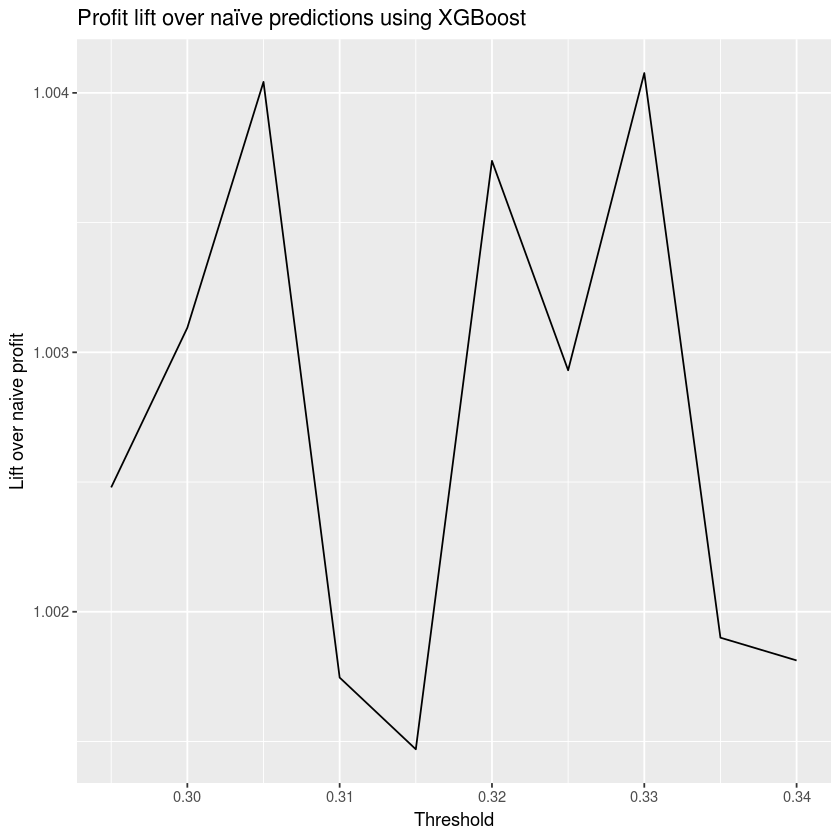

In [62]:
xgb.CSL.cv.opt2.df <- as.data.frame(xgb.CSL.cv.opt2)
ggplot(xgb.CSL.cv.opt2.df[which(xgb.CSL.cv.opt2.df$performance>0),], aes(x = thresholds, y = performance)) +
  geom_line() +
  labs(title = "Profit lift over naïve predictions using XGBoost",
          x = "Threshold", y = "Lift over naive profit")

**Set Optimal Threshold for CSL on a 0.005 scale**

In [63]:
xgb.CSL.cv.opt2.threshold <- xgb.CSL.cv.opt2.df$thresholds[which.max(xgb.CSL.cv.opt2.df$performance)]
xgb.CSL.cv.opt2.threshold

[1] 0.33

#### 4.2.2) Run & Test XGBoost on Optimal Params but on Full Training Set

**Set Optimal Params for Non-Monotonic**

In [64]:
xgb.cv.bayes.opt.params <- list(
    booster = "gbtree",
    max_depth = xgb.cv.bayes.opt$Best_Par["max_depth"],
    min_child_weight = xgb.cv.bayes.opt$Best_Par["min_child_weight"],
    eta = xgb.cv.bayes.opt$Best_Par["eta"],
    gamma = xgb.cv.bayes.opt$Best_Par["gamma"],
    subsample = 0.9, #xgb.cv.bayes.opt$Best_Par["subsample"],
    colsample_bytree = 0.8, #xgb.cv.bayes.opt$Best_Par["colsample_bytree"],
    #max_delta_step = xgb.cv.bayes.opt$Best_Par["max_delta_step"], 
    objective = "binary:logistic",
    eval_metric=c("logloss", "auc", "aucpr", "error")
)

**Train model on full training set**

In [65]:
stime <- Sys.time()
xgb.opt.mdl <- xgb.train(params = xgb.cv.bayes.opt.params, nrounds = xgb.cv.bayes.opt.nrounds, data = dtrain.1hot, 
                              verbose=1, print_every_n=30)
print(Sys.time() - stime)

Time difference of 2.044394 mins


**Get Predictions using Test Dataset**

In [66]:
xgb.opt.pred <- predict(xgb.opt.mdl, as.matrix(x_test.1hot))

**Plot ROC Curve**

In [67]:
xgb.opt.pred.fg <- xgb.opt.pred[y_test$default==TRUE]
xgb.opt.pred.bg <- xgb.opt.pred[y_test$default==FALSE]

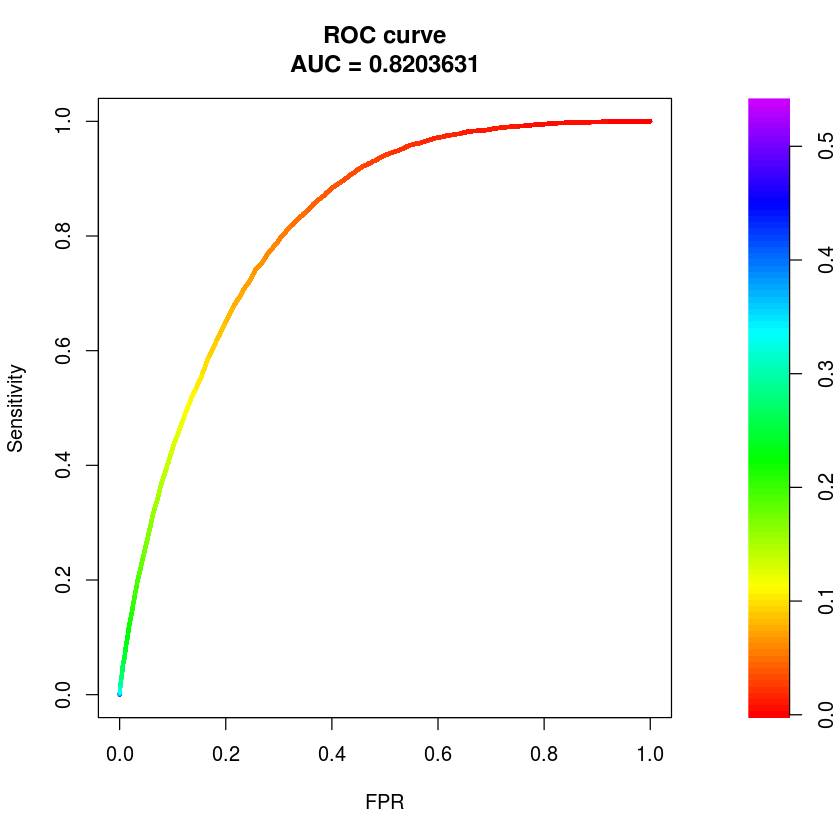

In [68]:
xgb.opt.roc <- roc.curve(scores.class0 = xgb.opt.pred.fg, scores.class1 = xgb.opt.pred.bg, curve = T)
plot(xgb.opt.roc)

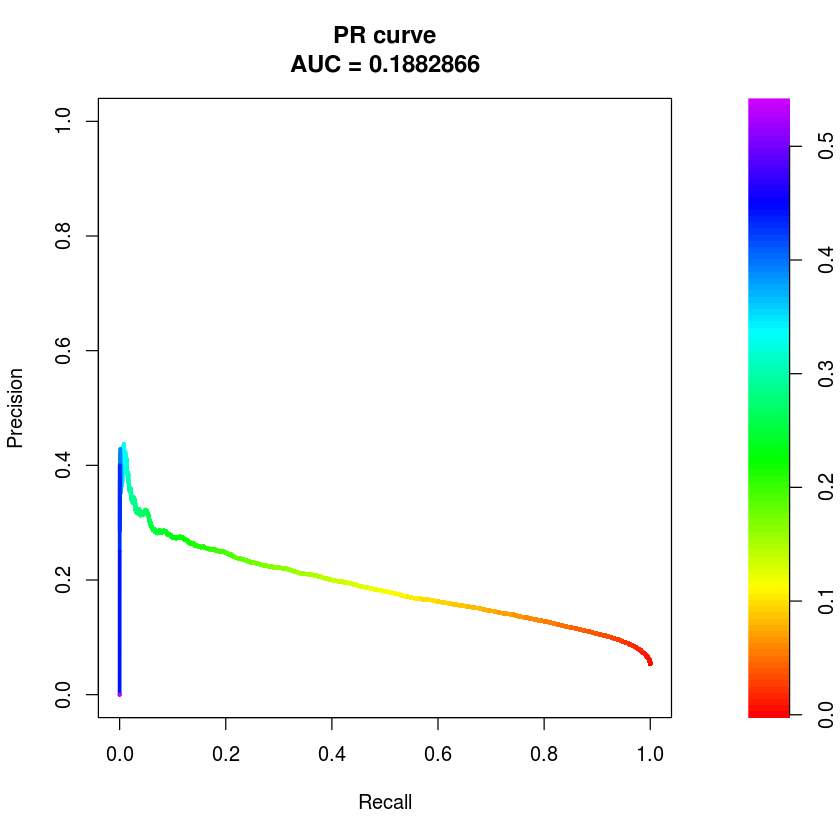

In [69]:
xgb.opt.prc <- pr.curve(scores.class0 = xgb.opt.pred.fg, scores.class1 = xgb.opt.pred.bg, curve = T)
plot(xgb.opt.prc)

**Calculate AUC**

In [70]:
xgb.opt.auc <- auc(roc(y_test$default, xgb.opt.pred))
xgb.opt.auc

Area under the curve: 0.8204

**Calculate F-score**

In [71]:
xgb.opt.f1 <- F1_Score(ifelse(xgb.opt.pred > 0.5, 1, 0), ifelse(y_test$default, 1, 0), positive = "0")
xgb.opt.f1

[1] 0.9726486

**Generate and Save Confusion Matrix**

In [103]:
xgb.opt.cm <- confusionMatrix(table(xgb.opt.pred > xgb.CSL.cv.opt2.threshold, y_test$default))
xgb.opt.cm

Confusion Matrix and Statistics

       
         FALSE   TRUE
  FALSE 117804   4859
  TRUE    7818   2204
                                         
               Accuracy : 0.9045         
                 95% CI : (0.9029, 0.906)
    No Information Rate : 0.9468         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.2086         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.9378         
            Specificity : 0.3120         
         Pos Pred Value : 0.9604         
         Neg Pred Value : 0.2199         
             Prevalence : 0.9468         
         Detection Rate : 0.8878         
   Detection Prevalence : 0.9245         
      Balanced Accuracy : 0.6249         
                                         
       'Positive' Class : FALSE          
                                         

**Calculate Feature Importance/Influence**

In [73]:
xgb.opt.imp <- xgb.importance(model = xgb.opt.mdl)
print(xgb.opt.imp)

                                   Feature         Gain        Cover
 1:                               int_rate 2.882493e-01 1.732934e-01
 2: quantity_indexes_for_real_gdp_by_state 2.336989e-01 1.983853e-01
 3:                      real_gdp_by_state 7.803379e-02 6.052762e-02
 4:                  initial_list_status_F 7.267242e-02 5.178454e-02
 5:        taxes_on_production_and_imports 4.306518e-02 4.280878e-02
 6:           per_capita_real_gdp_by_state 3.820846e-02 4.640008e-02
 7:                              subsidies 3.798843e-02 6.787224e-02
 8:                gross_operating_surplus 3.729927e-02 6.508382e-02
 9:                             annual_inc 3.511635e-02 4.551527e-02
10:              compensation_of_employees 3.215348e-02 4.292401e-02
11:                                  month 2.847619e-02 4.806333e-02
12:                                grade_A 1.184410e-02 1.331042e-02
13:                 purpose_SMALL_BUSINESS 7.400719e-03 1.282491e-02
14:                               

**Plot Importance/Influence**

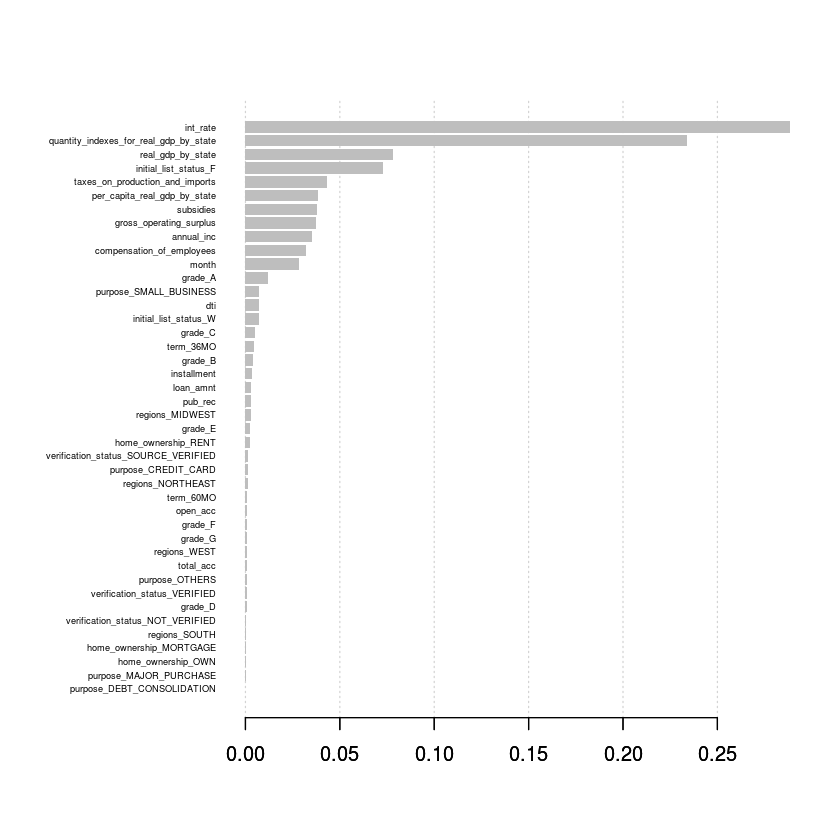

In [74]:
xgb.plot.importance(importance_matrix = xgb.opt.imp)

**Dump Tree**

In [75]:
xgb.dump(xgb.opt.mdl, with.stats = T, fname = "./models/xgb.opt.tree.costopt.txt")

Warning message:
“'with.stats' is deprecated.
Use 'with_stats' instead.
See help("Deprecated") and help("xgboost-deprecated").”

[1] TRUE

**Save Model**

In [76]:
xgb.save(xgb.opt.mdl, "./models/xgb.opt.costopt.mdl")

[1] TRUE

**Partial Graph (for 3 top vars)**

In [87]:
stime <- Sys.time()
xgb.opt.mdl.1p <- partial(xgb.opt.mdl, pred.var = "int_rate", train = x_train.1hot,
                         grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

Time difference of 17.59039 mins


In [88]:
stime <- Sys.time()
xgb.opt.mdl.2p <- partial(xgb.opt.mdl, pred.var = "quantity_indexes_for_real_gdp_by_state", train = x_train.1hot,
                         grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

Time difference of 17.81613 mins


In [89]:
stime <- Sys.time()
xgb.opt.mdl.3p <- partial(xgb.opt.mdl, pred.var = "annual_inc", train = x_train.1hot,
                         grid.resolution = 250, trim.outliers = FALSE, prob = TRUE, rug = TRUE, plot = TRUE)
print(Sys.time() - stime)

Time difference of 16.83963 mins


#### 4.2.4) Calculate Model Relative Losses

In [255]:
xgb.opt.NIR <- sum(xgb.opt.cm$table[,1])/sum(xgb.opt.cm$table)
xgb.opt.costs <- ((xgb.opt.cm$table[1,2]*mloan_amnt)+(xgb.opt.cm$table[2,1]*mreturns))
xgb.opt.profits <- (xgb.opt.cm$table[1,1]*mreturns) - (xgb.opt.cm$table[1,2]*mloan_amnt)
xgb.opt.naive <- (round(xgb.opt.NIR * sum(xgb.opt.cm$table[1,]),0)*mreturns)-(round((1-xgb.opt.NIR) * sum(xgb.opt.cm$table[1,]),0)*mloan_amnt)
xgb.opt.best <- ((sum(xgb.opt.cm$table[,1])*mreturns))
xgb.opt.worst <- (sum(xgb.opt.cm$table[,1])*mreturns)+(sum(xgb.opt.cm$table[,2])*mloan_amnt)
xgb.opt.lift.ratio <- xgb.opt.profits / xgb.opt.naive
xgb.opt.worst.ratio <- xgb.opt.worst / xgb.opt.best
xgb.opt.cost.ratio <- xgb.opt.costs / xgb.opt.best
xgb.opt.lift.ratio

[1] 1.110491

In [169]:
threshs <- seq(0.15, 0.35, by = 0.0025)
crs <- c()
rets <- c()
for(i in 1:length(threshs)) {
    cm <- confusionMatrix(table(xgb.opt.pred > threshs[i], y_test$default))
    cr <- ((cm$table[1,2]*mloan_amnt)+(cm$table[2,1]*mreturns)) / (sum(cm$table[,1])*mreturns)
    print(paste(threshs[i],cr,sum(cm$table[,1])*mreturns))
    crs <- c(crs,cr)
    rets <- c(rets, sum(cm$table[1,])*mreturns)
}
min(crs) #xgb.CSL.cv.opt2.threshold = 0.16 #0.43
max(rets)

[1] "0.15 0.244203619308192 350083389.6"
[1] "0.1525 0.244255501804019 350083389.6"
[1] "0.155 0.243686691040882 350083389.6"
[1] "0.1575 0.243046323612264 350083389.6"
[1] "0.16 0.242668475351165 350083389.6"
[1] "0.1625 0.242810807154045 350083389.6"
[1] "0.165 0.243311139375463 350083389.6"
[1] "0.1675 0.243257129386524 350083389.6"
[1] "0.17 0.24356916704168 350083389.6"
[1] "0.1725 0.243464770200568 350083389.6"
[1] "0.175 0.243434597960714 350083389.6"
[1] "0.1775 0.24361939964489 350083389.6"
[1] "0.18 0.243677052194538 350083389.6"
[1] "0.1825 0.243753119785264 350083389.6"
[1] "0.185 0.244184693531658 350083389.6"
[1] "0.1875 0.244059257131918 350083389.6"
[1] "0.19 0.244016135977221 350083389.6"
[1] "0.1925 0.243954426108539 350083389.6"
[1] "0.195 0.244624811528047 350083389.6"
[1] "0.1975 0.245128115612829 350083389.6"
[1] "0.2 0.245570447938784 350083389.6"
[1] "0.2025 0.245951851924139 350083389.6"
[1] "0.205 0.246240399176025 350083389.6"
[1] "0.2075 0.247080707538945 35

[1] 0.2426685

[1] 369577056

### 4.3) Compare Models

#### 4.3.1) Plot Monotonic Constraint Differences for Top 3 features

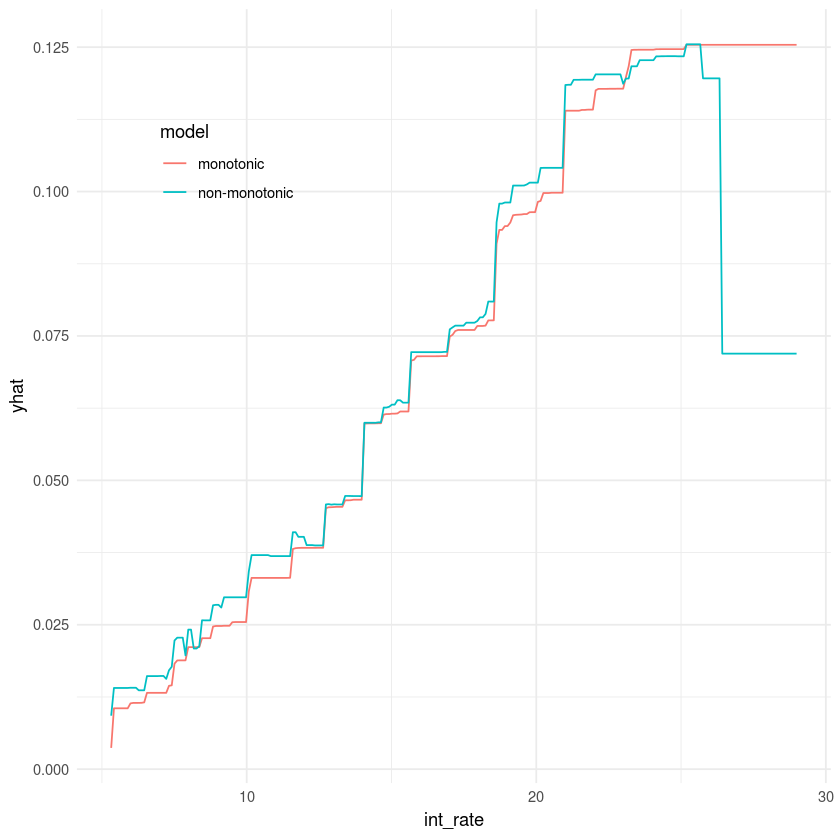

In [90]:
xgb.mono.opt.mdl.1p.df <- as.data.frame(xgb.mono.opt.mdl.1p$panel.args)
xgb.mono.opt.mdl.1p.df$model <- "monotonic"
xgb.opt.mdl.1p.df <- as.data.frame(xgb.opt.mdl.1p$panel.args)
xgb.opt.mdl.1p.df$model <- "non-monotonic"
xgb.opt.mdl.1p.df <- rbind.data.frame(xgb.mono.opt.mdl.1p.df, xgb.opt.mdl.1p.df)
ggplot(xgb.opt.mdl.1p.df, aes(x=x, y=y)) + geom_line(aes(colour = model)) +
            xlab("int_rate") + ylab("yhat") + theme_minimal() + theme(legend.position=c(0.2, 0.8))

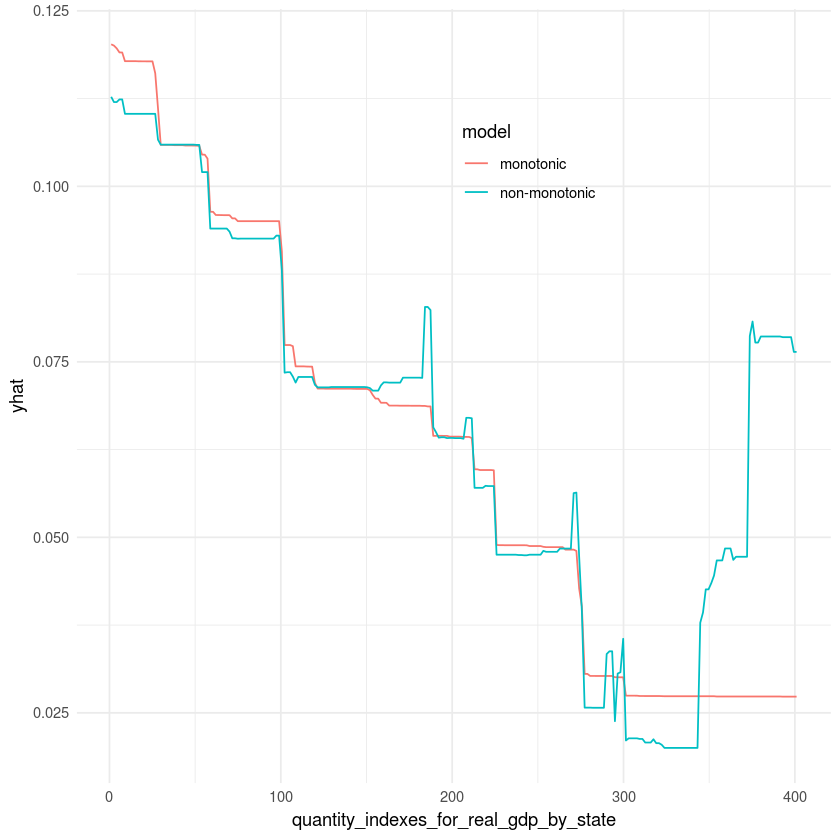

In [91]:
xgb.mono.opt.mdl.2p.df <- as.data.frame(xgb.mono.opt.mdl.2p$panel.args)
xgb.mono.opt.mdl.2p.df$model <- "monotonic"
xgb.opt.mdl.2p.df <- as.data.frame(xgb.opt.mdl.2p$panel.args)
xgb.opt.mdl.2p.df$model <- "non-monotonic"
xgb.opt.mdl.2p.df <- rbind.data.frame(xgb.mono.opt.mdl.2p.df, xgb.opt.mdl.2p.df)
ggplot(xgb.opt.mdl.2p.df, aes(x=x, y=y)) + geom_line(aes(colour = model)) +
            xlab("quantity_indexes_for_real_gdp_by_state") + ylab("yhat") + theme_minimal() + theme(legend.position=c(0.6, 0.8))

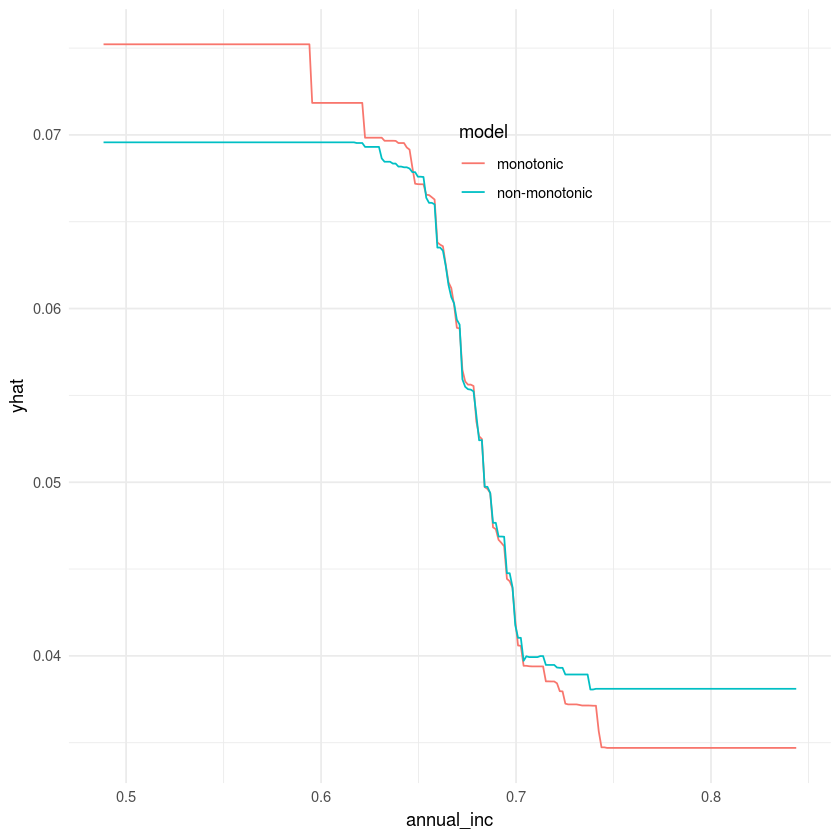

In [92]:
xgb.mono.opt.mdl.3p.df <- as.data.frame(xgb.mono.opt.mdl.3p$panel.args)
xgb.mono.opt.mdl.3p.df$model <- "monotonic"
xgb.opt.mdl.3p.df <- as.data.frame(xgb.opt.mdl.3p$panel.args)
xgb.opt.mdl.3p.df$model <- "non-monotonic"
xgb.opt.mdl.3p.df <- rbind.data.frame(xgb.mono.opt.mdl.3p.df, xgb.opt.mdl.3p.df)
ggplot(xgb.opt.mdl.3p.df, aes(x=x, y=y)) + geom_line(aes(colour = model)) +
            xlab("annual_inc") + ylab("yhat") + theme_minimal() + theme(legend.position=c(0.6, 0.8))

#### 4.3.2) Compare Metrics

In [254]:
options(scipen=999)
makeCMStatsCol <- function(cm, colname, costs, best, worst, ratio){
    cm.df1 <- as.data.frame(cm$overall)
    colnames(cm.df1) <- c(colname)
    cm.df2 <- as.data.frame(cm$byClass) 
    colnames(cm.df2) <- c(colname)
    cm.df3 <- data.frame(costs)
    row.names(cm.df3) <- c("COSTS")
    colnames(cm.df3) <- c(colname)
    cm.df4 <- data.frame(best)
    row.names(cm.df4) <- c("BEST CASE")
    colnames(cm.df4) <- c(colname)
    cm.df5 <- data.frame(worst)
    row.names(cm.df5) <- c("LIFT RATIO")
    colnames(cm.df5) <- c(colname)
    cm.df6 <- data.frame(ratio)
    row.names(cm.df6) <- c("COST RATIO")
    colnames(cm.df6) <- c(colname)
    cm.df <- rbind(cm.df1, cm.df2, cm.df3, cm.df4, cm.df5, cm.df6) 
    cm.df <- round(cm.df, 5)
    return(cm.df)
}
cbind(
    makeCMStatsCol(xgb.mono.opt.cm, "Monotonic XGBoost", xgb.mono.opt.costs, xgb.mono.opt.best, xgb.mono.opt.lift.ratio, xgb.mono.opt.cost.ratio),
    makeCMStatsCol(xgb.opt.cm, "Non-Monotonic XGBoost", xgb.opt.costs, xgb.opt.best, xgb.opt.lift.ratio, xgb.opt.cost.ratio)
)

,Monotonic XGBoost,Non-Monotonic XGBoost
Accuracy,0.92203,0.90446
Kappa,0.17235,0.20858
AccuracyLower,0.92058,0.90286
AccuracyUpper,0.92347,0.90603
AccuracyNull,0.94677,0.94677
AccuracyPValue,1.00000,1.00000
McnemarPValue,0.00000,0.00000
Sensitivity,0.96272,0.93777
Specificity,0.19836,0.31205
Pos Pred Value,0.95528,0.96039
